### Student Information
Name: 莊智宇

Student ID: 113065540

GitHub ID: yuuch3

Kaggle name: yuuch3

Kaggle private scoreboard snapshot:
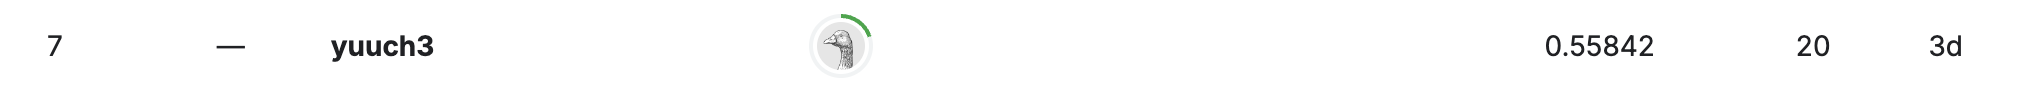

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [2]:
### Begin Assignment Here

# First: DM2024-Lab2-master

https://github.com/yuuch3/DM2024-Lab2-Master

# Second: Kaggle Competition

# Third: Model Code

Use the BERTweet model: https://github.com/VinAIResearch/BERTweet

## 1. Preprocessing

In [ ]:
import pandas as pd
import json
import re

# The BERTweet model has tweets text normalization function.
from TweetNormalizer import normalizeTweet

In [ ]:
# Data Path
tweets_DM_path = "./dm-2024-isa-5810-lab-2-homework/tweets_DM.json"
data_identification_path = "./dm-2024-isa-5810-lab-2-homework/data_identification.csv"
emotion_data_path = "./dm-2024-isa-5810-lab-2-homework/emotion.csv"

In [ ]:
# Use pandas to read the data
data_identification = pd.read_csv(data_identification_path)
emo_data = pd.read_csv(emotion_data_path)

print(data_identification.head())
print(emo_data.head())

In [ ]:
# Split train data and test data
train_data = data_identification[data_identification["identification"]=="train"]
test_data = data_identification[data_identification["identification"]=="test"]

In [ ]:
# Merge the train data and emotion data(ground truth labels)
train_emotion_data = pd.merge(train_data, emo_data, on='tweet_id', how='inner')
train_emotion_data = train_emotion_data.drop(columns=['identification'])

print(train_emotion_data.head())

In [ ]:
# Check if there are any missing value
print(train_emotion_data.isnull().sum())

In [ ]:
# Load the tweets_DM.json and the tweets text
tweets_data = []
with open(tweets_DM_path, 'r', encoding='utf-8') as f:
    for line in f:
        tweets_data.append(json.loads(line.strip())["_source"]["tweet"])

In [ ]:
# Change the tweets text to pandas DataFrame
tweets_data = pd.DataFrame(tweets_data)
print(tweets_data.head())

In [ ]:
# Check if there are any missing value
print(tweets_data.isnull().sum())

In [ ]:
# Merge train_emotion_data and tweets_data
train_emotion_data = pd.merge(train_emotion_data, tweets_data, on='tweet_id', how='inner')
print(train_emotion_data.head())

In [ ]:
# Observe the text data
for i in range(0,20):
    print(train_emotion_data["text"][i])

In [ ]:
# Remove the <LH> labels, and normalize the tweets text data using the BERTweet model's function
for i in range(0, len(train_emotion_data)):
    train_emotion_data.loc[i, "cleaned_text"] = normalizeTweet(re.sub(r'<LH>', '', train_emotion_data.loc[i, "text"]))

In [ ]:
# Observe the text data after preprocessing
for i in range(0, 20):
    print(train_emotion_data["cleaned_text"][i])

## 2. Sentence embedding

In [ ]:
# Define the hyperparameters
lr = 1e-5
epochs = 3
batch_size = 64
emotion_num = 8

In [ ]:
# Define the dictionary of emotions
emotion_map = {
    'anger': 0,
    'anticipation': 1,
    'disgust': 2,
    'fear': 3,
    'sadness': 4,
    'surprise': 5,
    'trust': 6,
    'joy': 7
}

emotion_map_2 = {
    0: 'anger',
    1: 'anticipation',
    2: 'disgust',
    3: 'fear',
    4: 'sadness',
    5: 'surprise',
    6: 'trust',
    7: 'joy'
}

In [ ]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("vinai/bertweet-base", cache_dir="./cache/")

In [ ]:
# Define the dataset
import torch
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.iloc[index]
        return d

In [ ]:
# Define the collate_fn, and set the max_length=128 because of the limit of vinai/bertweet-base model.
def collate_fn(batch):

    batch_sentence = tokenizer([data["cleaned_text"] for data in batch], truncation=True, padding=True, return_tensors="pt", max_length=128)
    batch_emotion = torch.tensor([emotion_map[data["emotion"]] for data in batch]).unsqueeze(1)

    return batch_sentence, batch_emotion
    
dl_train = DataLoader(Dataset(train_emotion_data[["emotion", "cleaned_text"]]), batch_size=batch_size, collate_fn=collate_fn)

## 3. Model train

In [ ]:
# Use GPU to train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = transformers.AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=emotion_num, cache_dir="./cache/").to(device)

In [ ]:
# Set the optimizer(AdamW) and criterion(CrossEntropyLoss)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Start to train the model
from tqdm import tqdm

for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()

    for batch_sentence, batch_emotion in pbar:

        optimizer.zero_grad()

        # Move data to device
        batch_sentence.to(device)

        output_emo = model(**batch_sentence)

        loss = criterion(output_emo.logits, batch_emotion.view(-1).to(device))

        loss.backward()

        optimizer.step()

## 4. Prediction

In [ ]:
# Merge test_data and tweets_data
test_emotion_data = pd.merge(test_data, tweets_data, on='tweet_id', how='inner')
test_emotion_data = test_emotion_data.drop(columns=['identification'])

In [ ]:
# Remove the <LH> labels, and normalize the tweets text data using the BERTweet model's function
for i in range(0, len(test_emotion_data)):
    test_emotion_data.loc[i, "cleaned_text"] = normalizeTweet(re.sub(r'<LH>', '', test_emotion_data.loc[i, "text"]))

In [ ]:
# Observe the text data after preprocessing
for i in range(0, 20):
    print(test_emotion_data["cleaned_text"][i])

In [ ]:
# Define the collate_fn_test(no ground truth data), and set the max_length=128 because of the limit of vinai/bertweet-base model.
def collate_fn_test(batch):

    batch_sentence = tokenizer([data["cleaned_text"] for data in batch], truncation=True, padding=True, return_tensors="pt", max_length=512)

    return batch_sentence

dl_test = DataLoader(Dataset(test_emotion_data[["cleaned_text"]]), batch_size=batch_size, collate_fn=collate_fn_test)

In [ ]:
# Predict
test_emo_pred = []

pbar = tqdm(dl_test)
pbar.set_description(f"Test epoch")
model.eval()

with torch.no_grad():

  for batch_sentence in pbar:

    batch_sentence.to(device)

    output_test = model(**batch_sentence)
    predictions = torch.argmax(output_test.logits, dim=-1)
    test_emo_pred.extend([emotion_map_2[pred.item()] for pred in predictions])

In [ ]:
# Generate the submission file
test_emotion_data["emotion"] = test_emo_pred
test_emotion_data_final = test_emotion_data.drop(columns=["hashtags", "text", "cleaned_text"])
test_emotion_data_final = test_emotion_data_final.rename(columns={"tweet_id":"id"})
test_emotion_data_final.to_csv("./dm-2024-isa-5810-lab-2-homework/output.csv", index=False, encoding='utf-8')